First we import data.
The initial dataset contains wind power time series from 255 regions in Europe, which is 650MB.
We selected only time series from French regions and saved it to 'French_wind_data.csv' in the Git repository (50MB).
First, we import desired libraries and load data

In [131]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('French_wind_data.csv')
print(len(df))
df.head()

262968


,FR30,FR71,FR25,FR42,FR82,FR41,FR83,FR10,FR61,FR62,...,FR22,FR23,FR53,FR21,FR63,FR81,FR72,FR43,FR26,FR51
0,0.26794,0.41513,0.32820,0.0,0.45992,0.00145,0.03030,0.06000,0.95,0.52765,...,0.13900,0.18590,0.16226,0.01750,0.11215,0.69298,0.23560,0.02576,0.00694,0.23464
1,0.22122,0.47283,0.29598,0.0,0.51182,0.00073,0.02525,0.06312,0.95,0.53303,...,0.12225,0.17896,0.18071,0.02285,0.13943,0.71172,0.27274,0.09015,0.01537,0.16941
2,0.18312,0.51863,0.23563,0.0,0.56804,0.00206,0.03106,0.06948,0.95,0.52972,...,0.10785,0.16866,0.15153,0.02809,0.15958,0.71879,0.29724,0.13212,0.02435,0.11864
3,0.16910,0.51003,0.16884,0.0,0.56824,0.00669,0.03864,0.07818,0.95,0.44746,...,0.11023,0.17440,0.11620,0.03564,0.14783,0.68143,0.27871,0.14091,0.02914,0.07421
4,0.15121,0.44058,0.15007,0.0,0.51733,0.00998,0.04899,0.08013,0.95,0.34736,...,0.11102,0.19267,0.10129,0.03822,0.13083,0.60158,0.21166,0.11682,0.02502,0.07181


The data has 262968 rows corresponding each to the output power of a windmill in a given region averaged over one hour. 263968 hours represent 30 years of data.
As can be seen, data is normalized to 1, where 1 means that there is enough wind in the region to have an average windmill produce 100% of its nominal output power.
Next, we plot the first 1000 hours of wind power for 4 regions, called FR30, FR71, FR25 and FR42.

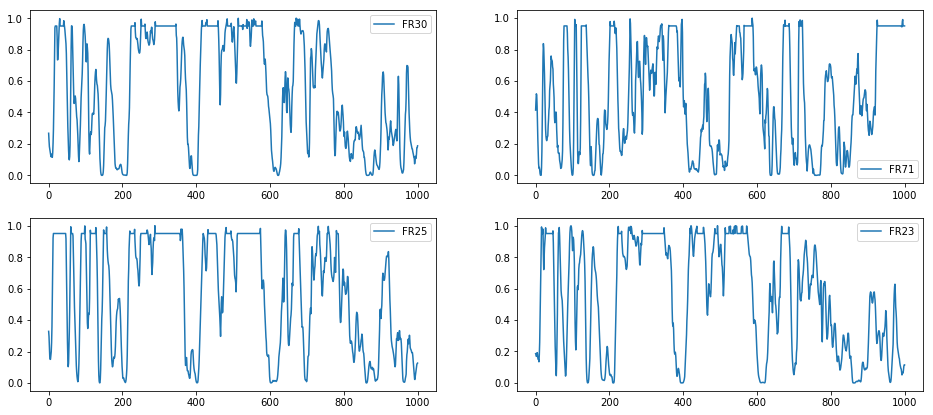

In [133]:
fig = plt.figure(figsize = (16, 7))
cols = ['FR30', 'FR71', 'FR25', 'FR23']
for i in range(4):
    P = fig.add_subplot(2, 2, i+1)
    P.plot(range(1001), df.loc[0:1000, cols[i]], label = cols[i])
    P.legend()
plt.show()

Wind power production is highly variable and can change very fast between 0 and 1. It is interesting to see that FR23, FR25 and FR30 seem highly correlated, while FR71 not so much.

Let's now compute the capacity factors (CF) of each region. That means how much average energy we can extract from a windmill in this region with nominal power of 1 over a long period of time (here 30 years!).
We save the results in a dictionary where keys are the names of the regions and values are the capacity factors.

In [134]:
CF = {}
for col in df.columns:
    CF[col] = np.mean(df[col])
    print(col + ': ' + str(CF[col]))

FR30: 0.3122650017491905
FR71: 0.3542998561039982
FR25: 0.3573299958168153
FR42: 0.12930007411548503
FR82: 0.2950181214825006
FR41: 0.16272984971555257
FR83: 0.1127869997110043
FR10: 0.19432017983176228
FR61: 0.5854473917358353
FR62: 0.24141895953119427
FR52: 0.29200040514435827
FR24: 0.18879264366767232
FR22: 0.23503440897752087
FR23: 0.3160449186592449
FR53: 0.26133604195186777
FR21: 0.163779056234977
FR63: 0.2236238365884608
FR81: 0.27688264180432826
FR72: 0.25242025832039716
FR43: 0.1252879319156515
FR26: 0.10463357267803858
FR51: 0.31653705842530616


As can be seen, there are 15 regions with CF < 0.29, so we'll discard them.
There are 6 regions with 0.29 < CF < 0.36, we will select these regions.
Finally there is 1 region with a very high CF=0.585, which corresponds to offshore wind.
Given that offshore wind is still a nascent industry with much higher costs than onshore, we will consider it apart.

In [135]:
cols = []
for col in list(CF):
    if ((CF[col] < 0.4) and (CF[col] > 0.29)):
        cols.append(col)
df2 = df[cols] # Onshore regions
df3 = df['FR61'] # Offshore region

In order to have a better idea of what the capacity factor means, let's plot the percentage of time each region has an output power higher than a given value for values between 0 and 1.

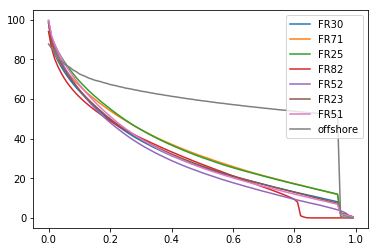

In [136]:
for col in df2.columns:
    M = []
    for i in range(100):
        M.append(100 * len(df2.loc[df2[col] > i/100, col]) / len(df2))
    plt.plot(np.arange(0,1,0.01), M, label=col)
    plt.legend()
M = []
for i in range(100):
    M.append(100 * len(df3[df3 > i/100]) / len(df3))
plt.plot(np.arange(0,1,0.01), M, label='offshore')
plt.legend()
plt.show()

The offshore platform performs clearly better with 95% efficiency >50% of the time (95% instead of 100% due to modelling assumptions in the dataset).
On the other hand, no onshore platform can even work at 80% efficiency 20% of the time. This means that the wind patterns have high variability, and this is why we are interested in combining multiple regions to decrease the variability of the power production.



Now that we have collected data about potential wind power production, we need to collect data about consumption, as we are interested in matching production and consumption. We find the relevant data on the governmnet website https://opendata.rte-france.com/pages/accueil/, where we selected a dataset that records French energy consumption every half hour between January 1st 2008 and present.

We saved the raw data as "Consumption_data.csv". Next, we sort the data by date, then we transform it into hourly data (to match the production data) and finally we select data from 2008 to 2015, as data about wind power ends in 2015. Finally, we also select wind power data from 2008 to 2015.

In [137]:
cons = pd.read_csv('Consumption_data.csv', sep = ';')
cons.sort_values(by=['Date','Heure'], ascending=[True,True], inplace = True)
cons['Cons_avg'] = (np.array(cons.iloc[:,3]) + np.array(pd.concat([cons.iloc[1:,3], cons.iloc[0:1,3]])))/2
cons = cons.iloc[2*np.arange(int(len(cons) / 2)),:]
cons = cons[:70128]
cons['year'] = pd.to_datetime(cons['Date']).dt.year
cons['month'] = pd.to_datetime(cons['Date']).dt.month
cons['day'] = pd.to_datetime(cons['Date']).dt.day
cons['hour'] = pd.to_datetime(cons['Heure']).dt.hour
cons = cons.iloc[:, 5:]
df2 = df2[-70128:]
df3 = pd.Series.to_frame(df3[-70128:])
df2['year'] = np.array(cons['year'])
df3['year'] = np.array(cons['year'])
df2['month'] = np.array(cons['month'])
df3['month'] = np.array(cons['month'])
df2['day'] = np.array(cons['day'])
df3['day'] = np.array(cons['day'])
df2['hour'] = np.array(cons['hour'])
df3['hour'] = np.array(cons['hour'])

Next, let's plot how the wind production profile and consumption profile evolve as a function of the month of the year and as a function of the time of the day, on average over the 8 years of the study. <br />
The first row shows the monthly consumption (left) and production (right). It is striking how much the consumption and wind production follow a similar trend, as winds are stronger in the winter when people consume more energy to heat buildings. The trend is a bit stronger for wind power, which is really low in the summer. This is a hint that solar energy may be the ideal complement of wind power during the summer [for further studies]. <br />
The second row shows the hourly consumption (left) and production (right). The main outcome here is that both average consumption and production profiles seem relatively flat, and the small variations are actually quite well correlated. <br />
Finally the last row shows the hourly consumption profile in January (left) and August (right), showing small differences such as the evening peak at 7pm in January, when people come back from work, and a 1pm peak in August due to AC. <br />

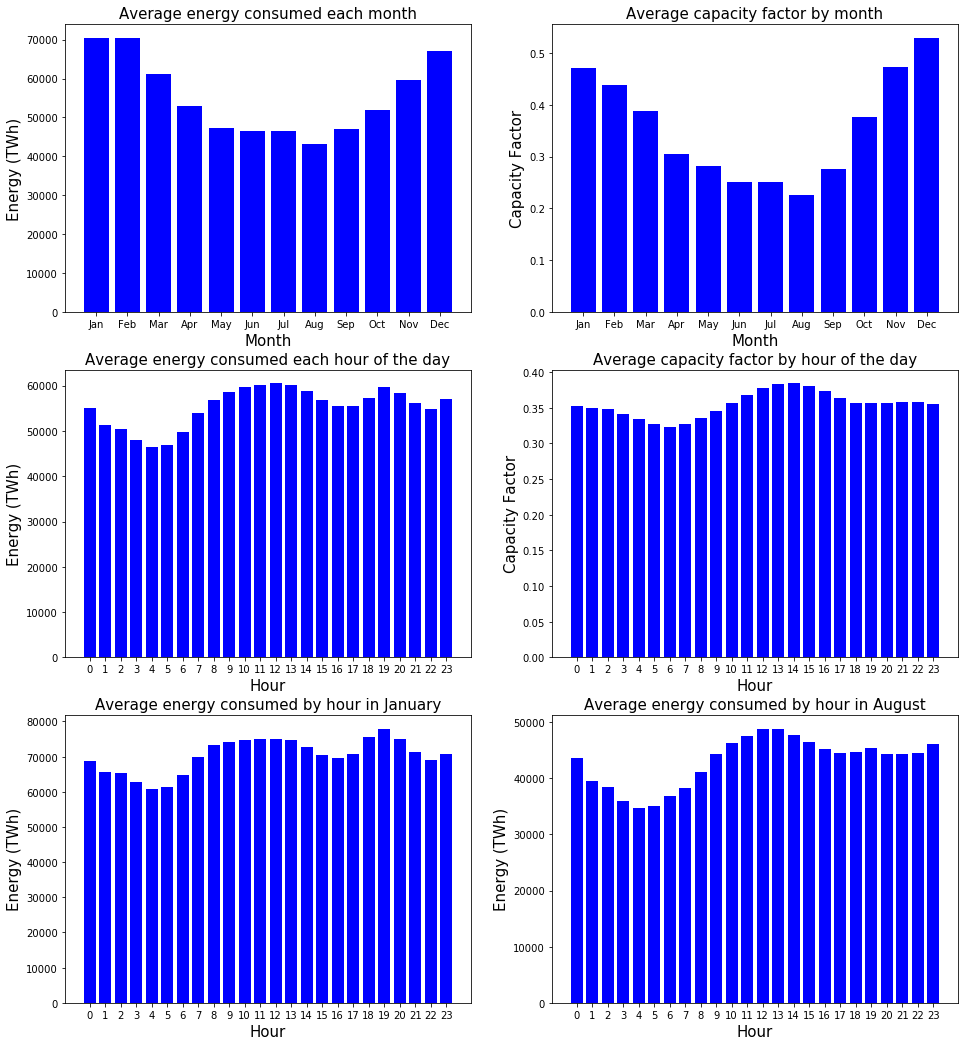

In [149]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_avgs, hour_avgs, Jan_hour, Aug_hour = [], [], [], []
wind_month, wind_hour = [], []
for m in range(1, 13):
    month_avgs.append(np.mean(cons.loc[cons.month == m, 'Cons_avg']))
    wind_month.append(np.mean(df2.loc[df2.month == m, 'FR25']))
for h in range(24):
    hour_avgs.append(np.mean(cons.loc[cons.hour == h, 'Cons_avg']))
    wind_hour.append(np.mean(df2.loc[df2.hour == h, 'FR25']))
    Jan_hour.append(np.mean(cons.loc[(cons.hour == h) & (cons.month == 1), 'Cons_avg']))
    Aug_hour.append(np.mean(cons.loc[(cons.hour == h) & (cons.month == 8), 'Cons_avg']))

fig = plt.figure(figsize = (16, 18))
P = fig.add_subplot(3, 2, 1)
P.bar(range(1, 13), month_avgs, color='b')
plt.xticks(range(1, 13), months, fontsize = 10)
plt.title('Average energy consumed each month', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Energy (TWh)', fontsize = 15)
P = fig.add_subplot(3, 2, 2)
P.bar(range(1, 13), wind_month, color='b')
plt.title('Average capacity factor by month', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Capacity Factor', fontsize = 15)
plt.xticks(range(1, 13), months, fontsize = 10)

P = fig.add_subplot(3, 2, 3)
P.bar(range(24), hour_avgs, color='b')
plt.xticks(range(24), range(24), fontsize = 10)
plt.title('Average energy consumed each hour of the day', fontsize = 15)
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Energy (TWh)', fontsize = 15)
P = fig.add_subplot(3, 2, 4)
P.bar(range(24), wind_hour, color='b')
plt.title('Average capacity factor by hour of the day', fontsize = 15)
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Capacity Factor', fontsize = 15)
plt.xticks(range(24), range(24), fontsize = 10)

P = fig.add_subplot(3, 2, 5)
P.bar(range(24), Jan_hour, color='b')
plt.xticks(range(24), range(24), fontsize = 10)
plt.title('Average energy consumed by hour in January', fontsize = 15)
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Energy (TWh)', fontsize = 15)
P = fig.add_subplot(3, 2, 6)
P.bar(range(24), Aug_hour, color='b')
plt.xticks(range(24), range(24), fontsize = 10)
plt.title('Average energy consumed by hour in August', fontsize = 15)
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Energy (TWh)', fontsize = 15)
plt.show()

# print(pd.to_datetime(cons['Date'])[0:5].dt.month)
# cons.head()

Although there seems to be a good correlation between wind production and consumption when averaged over 8 years, the day-to-day and hour-to-hour variations are much higher, as seen previously. This means that if a very large wind plant is built that can generate more than the total French consumption when wind is strong, there will also be times (no wind) when it will generate very little power. At those times, there needs to be other sources of power to match the demand. Here we will explore two sources: first is the use of wind plants in several regions in an optimal manner to "smoothen" the production profile. Second is the use of electricity storage to store energy when production is higher than demand and use it when wind stops blowing.

First, we show the regions that we will consider for onshore wind.

In [139]:
CF = {}
for col in df2.columns[0:6]:
    CF[col] = np.mean(df2[col])
    print(col + ': ' + str(CF[col]))

FR30: 0.3020866505532869
FR71: 0.3678113436858774
FR25: 0.35483294361742207
FR82: 0.30832697895276934
FR52: 0.2847037154916707
FR23: 0.30903095639403366


Second, we create two functions to compute, for a given hourly production and consumption vectors and with a given amount of storage, how much energy is produced (result[0]), how much wind energy is used (1), how much energy was stored before being used (2), how much energy could not be produced by wind power (3) and how much wind power was curtailed (4), all that as a percentage of the total French consumption over the 8 years.

In [142]:
def opt(prod, cons, storage):
    used, stored, total_stored, curtailed, missing = 0, 0, 0, 0, 0
    for i in range(len(prod)):
        p = prod[i]
        c = cons[i]
        used += min(p, c)
        if p < c:
            m = min(stored, c - p)
            used += m
            missing += (c - p - m)
            stored -= m    
        else:
            m = min(storage - stored, p - c)
            total_stored += m
            curtailed += (p - c - m)
            stored += m 
    result = np.array([sum(prod), used, total_stored, missing, curtailed])
    return np.round(result / sum(cons) * 100, 2)

def print_opt(result):
    print('Produced: ' + "{0:.2f}".format(result[0]))
    print('Used: ' + "{0:.2f}".format(result[1]))
    print('Total stored: ' + "{0:.2f}".format(result[2]))
    print('Missing: ' + "{0:.2f}".format(result[3]))
    print('Curtailed: ' + "{0:.2f}".format(result[4]))
    

Now, let's model how much useful energy we can get out of wind power in each region as a function of the wind plant size (Pmax in MW). Instantaneous power from the wind plant is P = Pmax * Eff where Eff is the efficiency as a function of time in df2.
Every time the power plant produces more than the consumption, some power must be "curtailed" and some energy is lost. 
Let's represent the efficiency of each region as a function of the power installed:
left = Total useful energy (in % of total consumption) vs size of the plant
right = Efficiency (in %) of a power plant as a function of the total useful energy

FR30
FR71
FR25
FR82
FR52
FR23


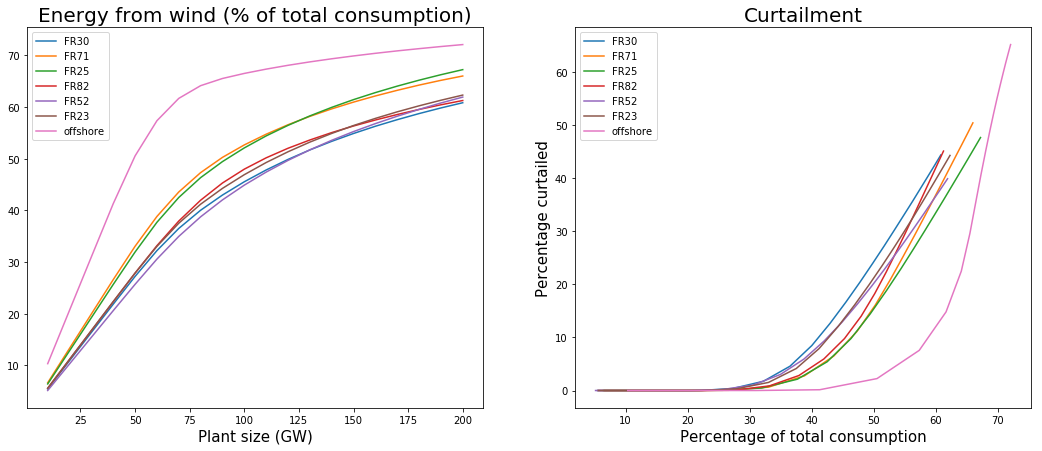

In [150]:
fig = plt.figure(figsize = (18, 7))
Energy1 = {}
Efficiency1 = {}
for col in df2.columns[0:6]:
    print(col)
    M = []
    N = []
    for i in range(1, 21):
        result = opt(np.array(i * 10e3 * df2[col]), np.array(cons.Cons_avg), 0)
        M.append(result[1])
        N.append(100 * result[4] / result[0])
    Energy1[col] = M
    Efficiency1[col] = N
    P = fig.add_subplot(1, 2, 1)
    plt.plot(np.arange(10,210,10), M, label=col)
    plt.legend()
    P = fig.add_subplot(1, 2, 2)
    plt.plot(M, N, label=col)
    plt.legend()
M, N = [], []
for i in range(1, 21):
    result = opt(np.array(i * 10e3 * df3['FR61']), np.array(cons.Cons_avg), 0)
    M.append(result[1])
    N.append(100 * result[4] / result[0])
P = fig.add_subplot(1, 2, 1)
plt.plot(np.arange(10,210,10), M, label='offshore')
plt.title('Energy from wind (% of total consumption)', fontsize = 20)
plt.xlabel('Plant size (GW)', fontsize = 15)
plt.legend()
P = fig.add_subplot(1, 2, 2)
plt.plot(M, N, label='offshore')
plt.title('Curtailment', fontsize = 20)
plt.xlabel('Percentage of total consumption', fontsize = 15)
plt.ylabel('Percentage curtailed', fontsize = 15)
plt.legend()
plt.show()

The graph on the left gives a clear idea of how the total useful energy of a plant increases with the size of the plant.
The graph on the right is probably the best way to evaluate the performance of each region in terms of tradeoffs between total useful energy and efficiency. The larger the plant, the more useful energy, but also the more power is curtailed.

An optimum of 30% of the total energy consumption can be provided by onshore wind with 100% efficiency (FR25 = Normandie, in the north-west of France), but in order to achieve 66% of the total consumption, one has to oversize the plant to 180GW, and 45% of produced energy will be curtailed.
The same amount of energy can be provided by 90GW of offshore wind (with 25% curtailment), which will be very attractive when the costs can decrease at 2 times the costs of onshore or less.

In the meantime, let's see if we can improve onshore wind by combining production from several regions, which will hopefully "smoothen" the overall production.
For that, let's assume we can install 180GW capacity in total. We will start with 100% of it in the best region (FR25), then we progressively replace some of this capacity in other regions if we can improve the total useful energy.

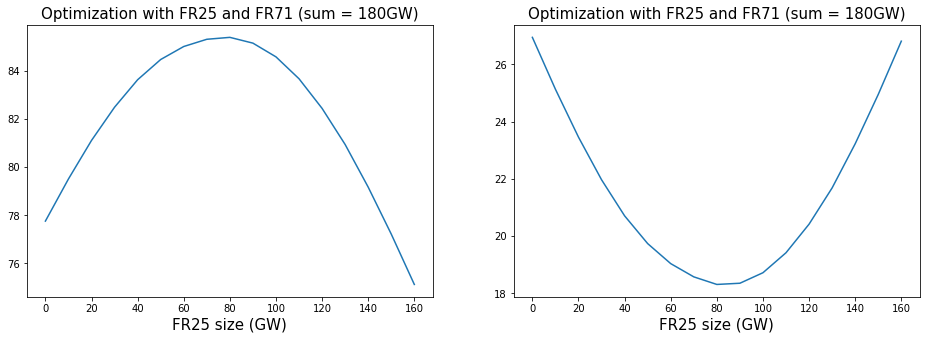

In [162]:
fig = plt.figure(figsize = (16, 5))
Energy = []
Efficiency = []
for i in range(17):
    result = opt(np.array(i * 10e3 * df2['FR25'] + (16 - i) * 10e3 * df2['FR71']), np.array(cons.Cons_avg), 1.2e6)
    Energy.append(result[1])
    Efficiency.append(100 * result[4] / result[0])
P = fig.add_subplot(1, 2, 1)
plt.plot(np.arange(0,170,10), Energy)
plt.title('Optimization with FR25 and FR71 (sum = 180GW)', fontsize = 15)
plt.xlabel('FR25 size (GW)', fontsize = 15)
P = fig.add_subplot(1, 2, 2)
plt.plot(np.arange(0,170,10), Efficiency)
plt.title('Optimization with FR25 and FR71 (sum = 180GW)', fontsize = 15)
plt.xlabel('FR25 size (GW)', fontsize = 15)
plt.show()

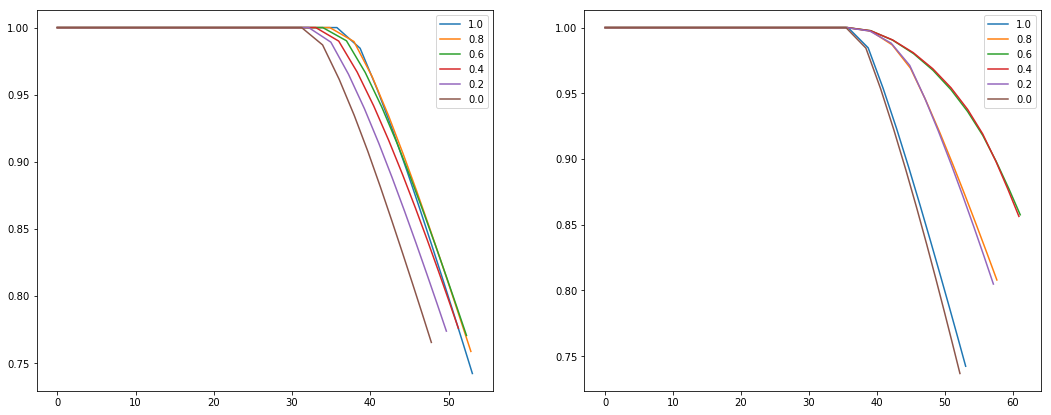

In [93]:
fig = plt.figure(figsize = (18, 7))
col1 = 'FR30'
P = fig.add_subplot(1, 2, 1)
for i in range(0, 11, 2):
    plt.plot(CF2[col1][0][i], CF2[col1][1][i], label=(10-i)/10)
    plt.legend()
col2 = 'FR71'
P = fig.add_subplot(1, 2, 2)
for i in range(0, 11, 2):
    plt.plot(CF2[col2][0][i], CF2[col2][1][i], label=(10-i)/10)
    plt.legend()
plt.show()

We tested all the regions but selected two of them. For both graphs, we represent the plant efficiency as a function of the total useful energy. 1.0 represents when 100% of the power comes from FR25, and 0.0 represents when 100% of the power comes from FR30/FR71.

FR30 (left graph) is an example of a region that, combined with FR25, doesn't improve the efficiency, which means that winds in both regions are highly correlated, so the power produced by each region cannot balance the power from the other region. It makes sense as these two regions are neighbors without any mountains in between.
FR71 (right graph) shows a totally different situation. Combining FR25 and FR71 50/50 allows to achieve 50% useful energy with 96% efficiency (as opposed to 80% for FR25 only), and even 60% useful energy with 89% efficiency (11% curtailment).

We also tested with 3 regions, but no significant improvement was noticed.

In [111]:
CF2off = {}
for col in df2.columns:
    Energy = []
    Efficiency = []
    for i in range(11):
        P1 = 0.1*i*df2[col] + (1-0.1*i)*df3
        P = []
        E = [1]
        for j in range(31):
            P.append(100 * np.mean(np.minimum(1, P1*j/10)))
        Energy.append(P)
        for j in range(1,31):
            E.append(P[j]/P[10] * 10/j)
        Efficiency.append(E)
    CF2off[col] = (Energy, Efficiency)

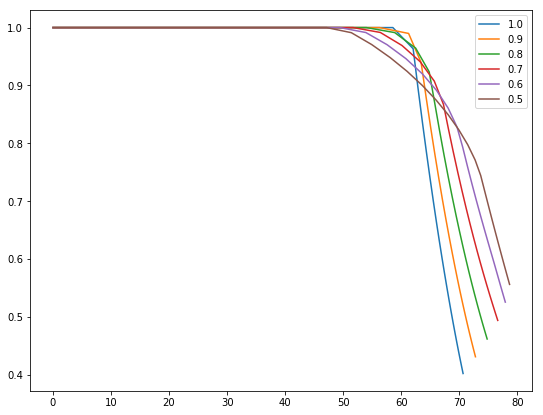

In [119]:
fig = plt.figure(figsize = (9, 7))
col1 = 'FR25'
for i in range(0, 6, 1):
    plt.plot(CF2off[col1][0][i], CF2off[col1][1][i], label=(10-i)/10)
    plt.legend()
plt.show()

Doing a similar procedure as previously, but this time with the offshore region + one region onshore (FR25 = Normandie), the useful wind energy can reach up to 72% of the total energy consumption with a 78% efficiency (22% curtailment), with 50% nominal power from offshore and 50% nominal power from FR25.

Next, let's plot a sample of power generation time series of 1000hours (40 days) for each interesting configuration.<br />
TS1: There is one power plant in FR25 providing 36% of total energy and running at 100% efficiency.<br />
TS2: The FR25 power plant is scaled up by a factor of 2, providing 50% of total energy at 80% efficiency.<br />
TS3: FR25 and FR71 are combined to provide 50% of total energy with 96% efficiency.<br />
TS4: FR25+FR71 are scaled up by 40%, providing 60% total energy with 89% efficiency.<br />
TS5: Offshore wind can provide up to 60% energy with 100% efficiency.<br />
TS6: Combining offshore wind and FR25 50/50, wind power can generate 72% of total energy with 78% efficiency.

In [155]:
TS1 = df['FR25']/0.94
TS2 = df['FR25']*2
TS3 = (df['FR25'] + df['FR71'])*0.8
TS4 = (df['FR25'] + df['FR71'])*1.1
TS5 = df['FR61']/0.94
TS6 = (df['FR61'] + df['FR25'])/0.94
TS = [TS1, TS2, TS3, TS4, TS5, TS6]
TS_name = ['FR25', 'FR25+', 'FR25-FR71', 'FR25-FR71+', 'offshore', 'offshore-FR25']

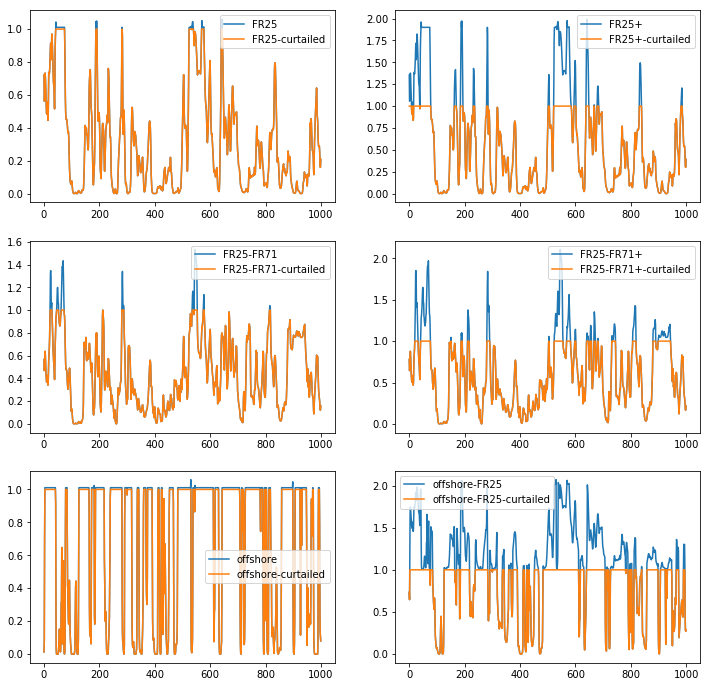

In [156]:
Legends = []

fig = plt.figure(figsize = (12, 12))
for i in range(6):
    P = fig.add_subplot(3, 2, i+1)
    P.plot(range(1000), TS[i][100000:101000], label=TS_name[i])
    P.plot(range(1000), np.minimum(1, TS[i][100000:101000]), label=TS_name[i]+'-curtailed')
    P.legend()
plt.show()

Finally, the next graph shows the percentage of hours when wind power provides more than a certain amount (x-axis) of total power. For example, we see that the configuration 'offshore+FR71' provides more than 50% of the power consumption 70% of the time, and more than 100% of the power consumption 60% of the time.

In [157]:
Hours_statistics = {}
for i in range(6):
    col = TS[i]
    Hours = []
    for j in range(11):
        Hours.append(100 * sum(col > j/10) / len(col))
    Hours_statistics[TS_name[i]] = Hours
        

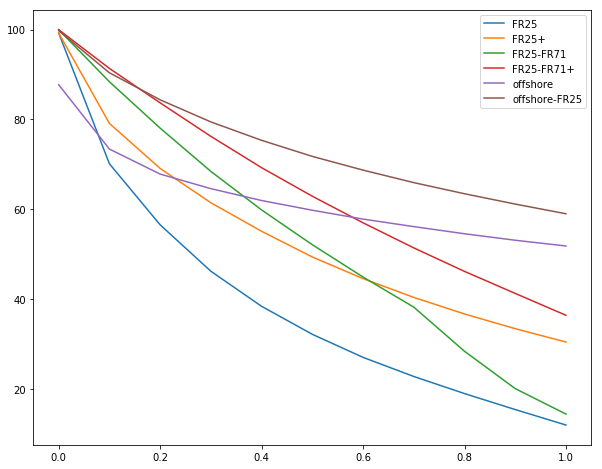

In [159]:
fig = plt.figure(figsize = (10, 8))
for i in range(6):
    plt.plot(np.arange(0,1.1, 0.1), Hours_statistics[TS_name[i]], label = TS_name[i])
plt.legend()
plt.show()

In [1]:
df.head()

NameError: name 'df' is not defined